In [ ]:
# Import necessary libraries
import sys
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

sys.path.append("../../src/data")
# Import API Stock data using the class in the stock_data_processor.py file
from stock_data_processor import APIStockProcessor

In [ ]:
# ----------------------------------------------------------------------------------------------
# 1. Use the APIStockProcessor class to prepare the stock for Microsoft
# ----------------------------------------------------------------------------------------------
# Create an instance of the APIStockProcessor class
asp = APIStockProcessor()

# Get the stock data for Microsoft (MSFT) using the get_stock_data method
df_microsoft = asp.get_stock_data(ticker="MSFT")
print(df_microsoft.head())
print("Full MSFT stock data", df_microsoft.shape)

               open     high     low   close      volume
date                                                    
2025-03-26  395.000  395.310  388.57  389.97  16132906.0
2025-03-25  393.915  396.360  392.64  395.16  15774968.0
2025-03-24  395.400  395.400  389.81  393.08  21004548.0
2025-03-21  383.215  391.740  382.80  391.26  39675928.0
2025-03-20  385.735  391.785  383.28  386.84  18470542.0
Full MSFT stock data (6389, 5)


In [ ]:
# Get the returns for Microsoft using the 'extract_returns' method
msft_stock_returns = asp.extract_returns(df_microsoft)

# Print the first five rows of the returns for Microsoft
print(msft_stock_returns.head())
print(msft_stock_returns.shape)
print(type(msft_stock_returns))

date
2015-04-20     3.099844
2015-04-21    -0.629297
2015-04-22     0.820922
2015-04-23     0.825869
2015-04-24    10.452238
Name: returns, dtype: float64
(2500,)
<class 'pandas.core.series.Series'>


In [ ]:
# ----------------------------------------------------------------------------------------------
# 2. Split the data into training set that contains the first 80% of the data
# ----------------------------------------------------------------------------------------------

# Calculate the index for the training set
int(0.8 * len(msft_stock_returns))

2000

In [ ]:
# Create the training set
msft_train = msft_stock_returns[: int(0.8 * len(msft_stock_returns))]
print(msft_train.shape)
print(msft_train.head())
print(msft_train.tail())

(2000,)
date
2015-04-20     3.099844
2015-04-21    -0.629297
2015-04-22     0.820922
2015-04-23     0.825869
2015-04-24    10.452238
Name: returns, dtype: float64
date
2023-03-22   -0.544233
2023-03-23    1.972162
2023-03-24    1.048044
2023-03-27   -1.493388
2023-03-28   -0.416094
Name: returns, dtype: float64


In [ ]:
# ----------------------------------------------------------------------------------------------
# 3. Build and Iterate on the Model
# ----------------------------------------------------------------------------------------------

# Initialize the model parameters and fit the model
model = arch_model(
    msft_train,
    p=1,
    q=1,
    rescale=False,  # Avoid rescaling the data for easier interpretation
).fit(
    disp="off"
)  # Turn off the convergence output to suppress the fiting output

In [ ]:
# Print the model summary to understand the model parameters
print(model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3731.07
Distribution:                  Normal   AIC:                           7470.15
Method:            Maximum Likelihood   BIC:                           7492.55
                                        No. Observations:                 2000
Date:                Thu, Mar 27 2025   Df Residuals:                     1999
Time:                        16:00:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1333  3.021e-02      4.411  1.027e-05 [7.406e-0

In [ ]:
"""
The model summary provides the following information:

- The mean return (mu) is positive and statistically significant,
indicating that the average return is significantly different from zero.
- The GARCH model parameters (omega, alpha[1], and beta[1]) describe the volatility dynamics of the returns:
  - **omega** is not statistically significant, meaning that
  the constant term in the volatility equation may not be necessary.
  - **alpha[1]** is statistically significant, indicating that past
  squared residuals (shocks) have a significant impact on current volatility.
  - **beta[1]** is highly statistically significant, indicating that 
  past volatility has a strong influence on current volatility.
- The high value of **beta[1]** (0.8106) suggests that volatility is persistent,
meaning that high volatility periods tend to be followed by high volatility periods.

Overall, the model captures the volatility clustering commonly observed in financial time series, where 
periods of high volatility are followed by high volatility and periods of low volatility are followed by low volatility.
"""

'\nThe model summary provides the following information:\n\n- The mean return (mu) is positive and statistically significant,\nindicating that the average return is significantly different from zero.\n- The GARCH model parameters (omega, alpha[1], and beta[1]) describe the volatility dynamics of the returns:\n  - **omega** is not statistically significant, meaning that\n  the constant term in the volatility equation may not be necessary.\n  - **alpha[1]** is statistically significant, indicating that past\n  squared residuals (shocks) have a significant impact on current volatility.\n  - **beta[1]** is highly statistically significant, indicating that \n  past volatility has a strong influence on current volatility.\n- The high value of **beta[1]** (0.8106) suggests that volatility is persistent,\nmeaning that high volatility periods tend to be followed by high volatility periods.\n\nOverall, the model captures the volatility clustering commonly observed in financial time series, where

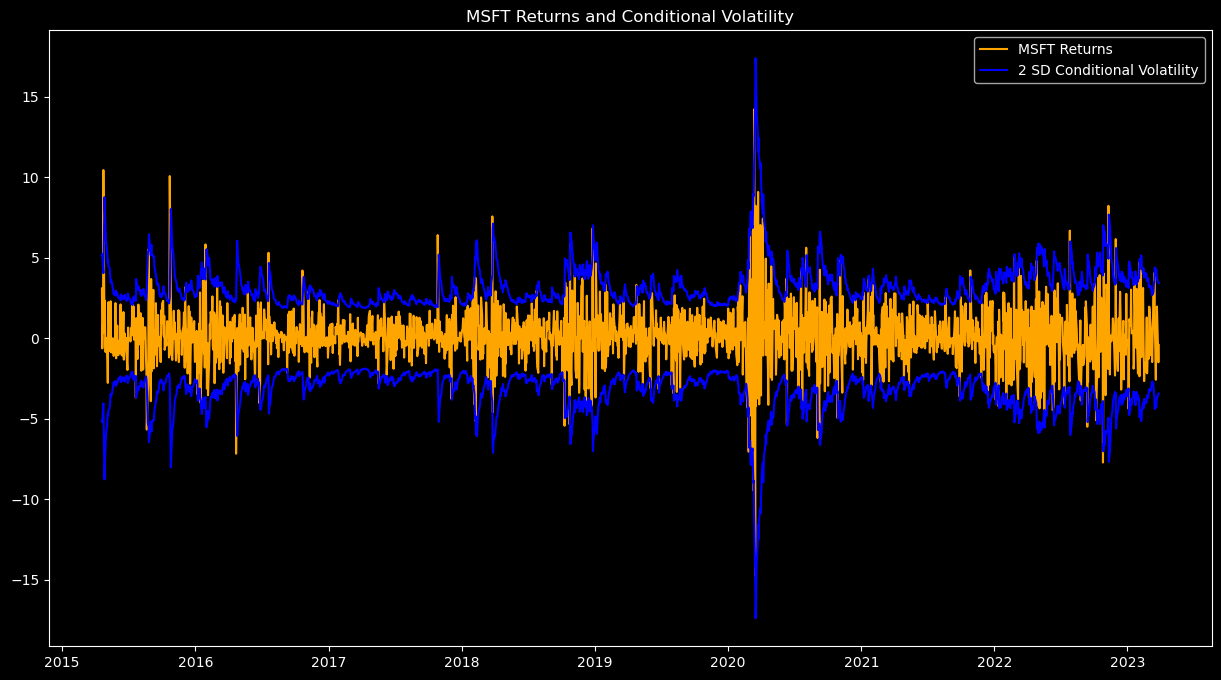

In [ ]:
# ----------------------------------------------------------------------------------------------
# 4. Plot the model diagnostics
# ----------------------------------------------------------------------------------------------

# Plot the time series of the msft_train data and the model's conditional volatility
fig = plt.figure(figsize=(15, 8))
fig.patch.set_facecolor("black")
plt.style.use("dark_background")

plt.plot(msft_train, label="MSFT Returns", color="Orange")
plt.plot(
    2 * model.conditional_volatility, label="2 SD Conditional Volatility", color="blue"
)  # Multiply by 2 for better visualization
plt.plot(
    -2 * model.conditional_volatility.rename(), color="blue"
)  # Multiply by -2 for better visualization
plt.title("MSFT Returns and Conditional Volatility")
plt.legend()
plt.show();

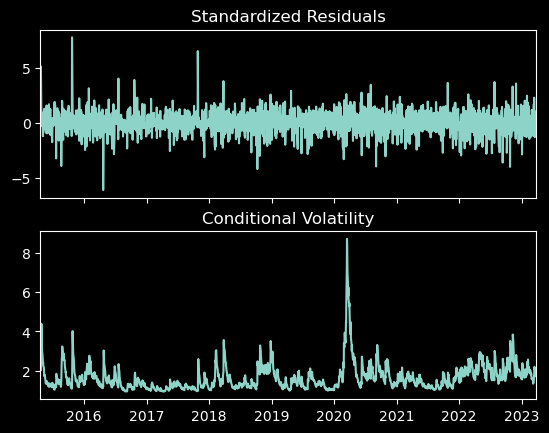

In [ ]:
# Plot the model diagnostics
model.plot()
plt.show();

In [ ]:
"""
The plot shows the following diagnostics:
- The standardized residuals are normally distributed with a mean close to zero.
- The model performs well in capturing the volatility clustering in the data.
"""

'\nThe plot shows the following diagnostics:\n- The standardized residuals are normally distributed with a mean close to zero.\n- The model performs well in capturing the volatility clustering in the data.\n'

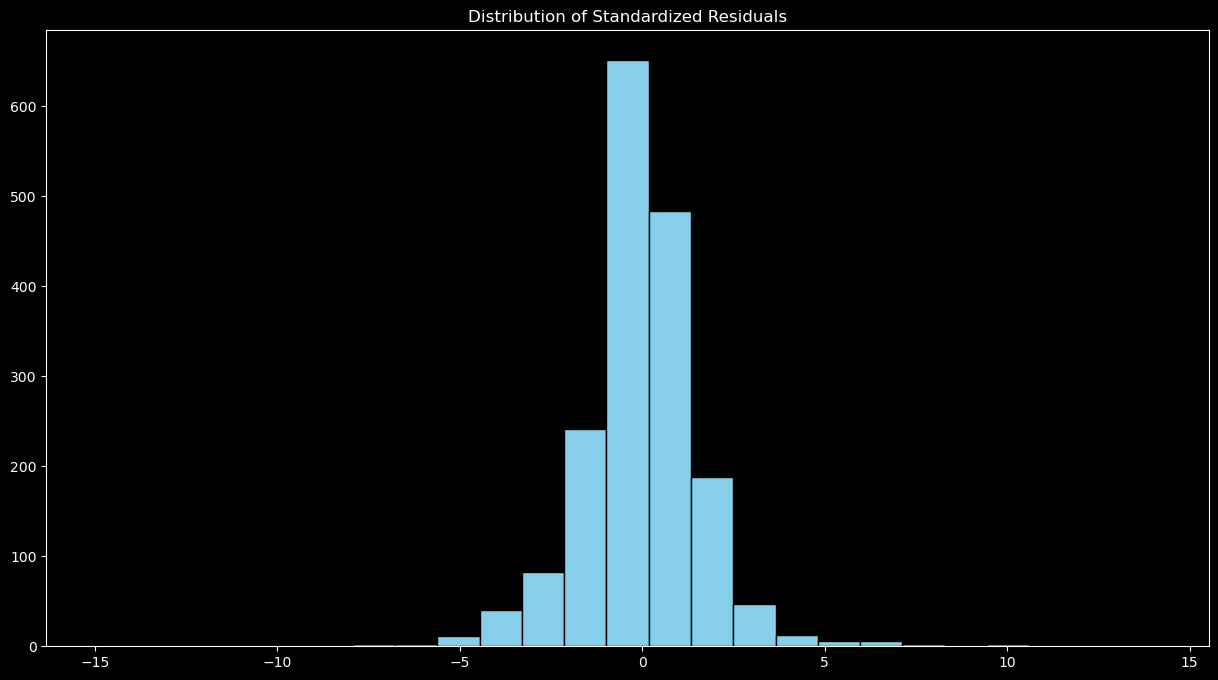

In [ ]:
# ----------------------------------------------------------------------------------------------

# Plot a histogram of the standardized residuals to better understand the normality assumption
plt.figure(figsize=(15, 8))
fig.patch.set_facecolor("black")
plt.style.use("dark_background")

plt.hist(model.resid, bins=25, color="skyblue", edgecolor="black")
plt.title("Distribution of Standardized Residuals")
plt.show();

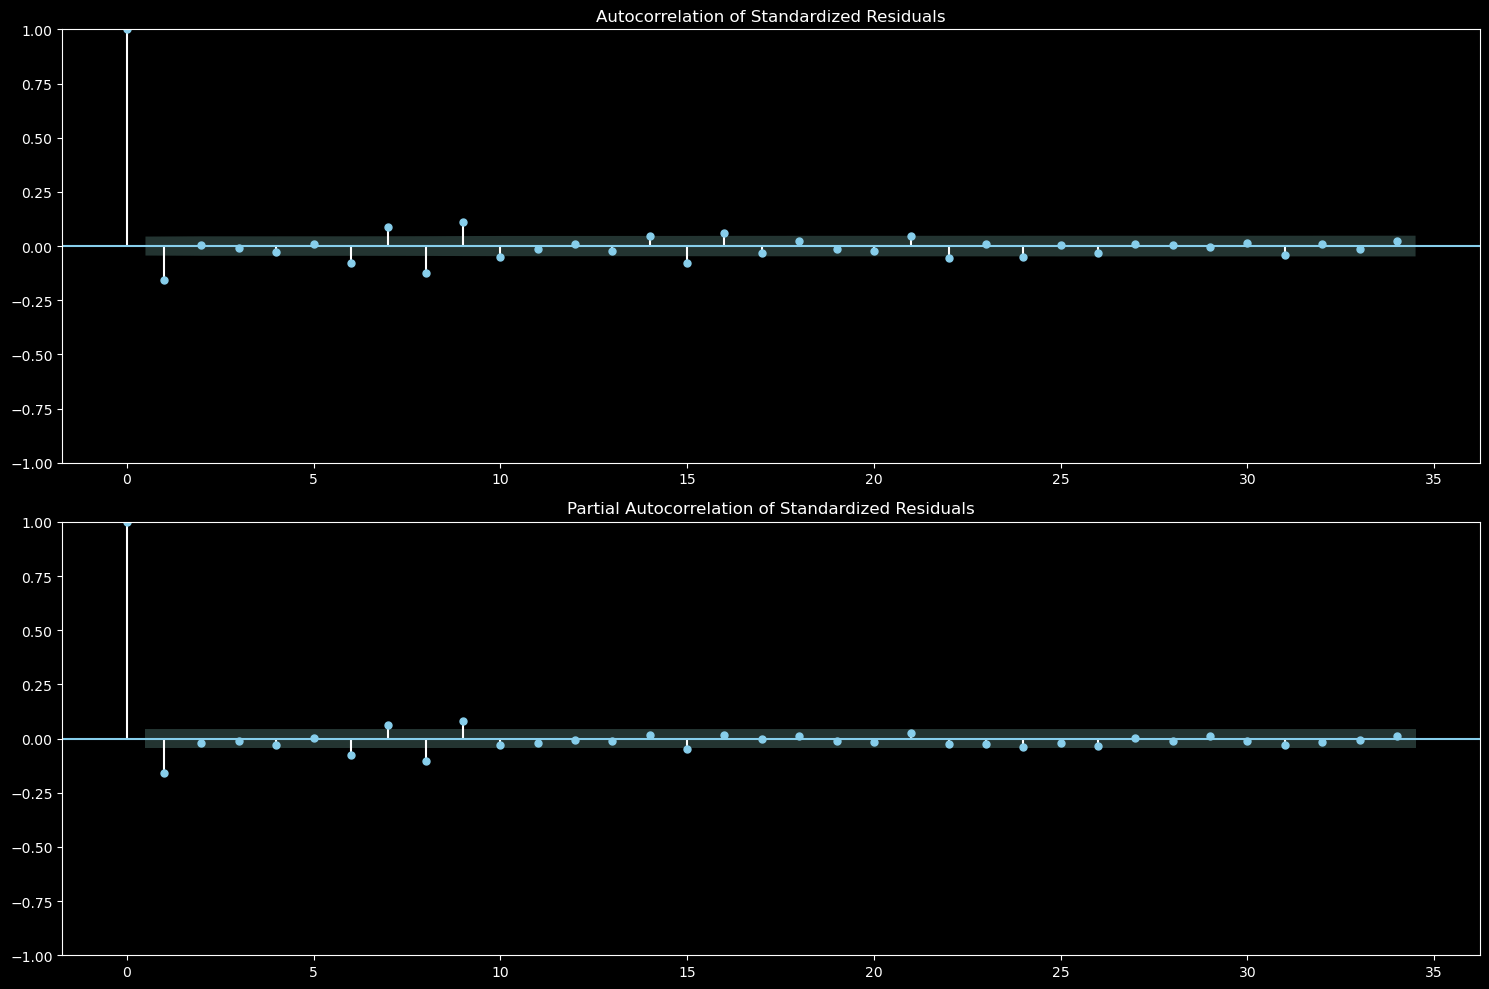

In [ ]:
# ----------------------------------------------------------------------------------------------

# Plot the autocorrelation and partial autocorrelation functions of the standardized residuals
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
fig.patch.set_facecolor("black")

plot_acf(model.resid, ax=ax[0], color="skyblue")
ax[0].set_title("Autocorrelation of Standardized Residuals")

plot_pacf(model.resid, ax=ax[1], color="skyblue")
ax[1].set_title("Partial Autocorrelation of Standardized Residuals")

plt.tight_layout()
plt.show();

In [ ]:
"""
The plots show that the residuals are not correlated, which means that the model
adequately captures the information in the data.
The lack of significant autocorrelation suggests that the model has
adequately captured the volatility dynamics of the returns.
"""

'\nThe plots show that the residuals are not correlated, which means that the model\nadequately captures the information in the data.\nThe lack of significant autocorrelation suggests that the model has\nadequately captured the volatility dynamics of the returns.\n'

In [ ]:
# ----------------------------------------------------------------------------------------------
# 5. Forecasting Volatility
# ----------------------------------------------------------------------------------------------

# Forecast the volatility for the next 10 days
forecast_horizon = 10
forecasted_volatility = (
    model.forecast(
        horizon=forecast_horizon, reindex=False  # Avoid reindexing the data
    ).variance
    ** 0.5
)  # Take the square root of the variance to get the volatility
forecasted_volatility

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
date,,,,,,,,,,
2023-03-28,1.601773,1.61206,1.621785,1.63098,1.63968,1.647911,1.655703,1.663081,1.670068,1.676687


In [ ]:
# ----------------------------------------------------------------------------------------------

# Model walk-fforward validation forecast on the test set to evaluate the model's performance
# Create an empty list to store the forecasted volatility
forecasted_volatility = []
test_size = int(len(msft_stock_returns) * 0.2)

# Iterate over the test set to forecast the volatility
for i in range(test_size):
    # Create the test set
    msft_test = msft_stock_returns.iloc[
        : -(test_size + i)
    ]  # The +i includes the current day
    # Fit the model on the test set
    model = arch_model(
        msft_test,
        p=1,
        q=1,
        rescale=False,
    ).fit(disp=0)

    # Forecast the volatility for the next day
    forecasted_volatility.append(
        model.forecast(horizon=1, reindex=False).variance.iloc[0, 0]
        ** 0.5  # The [0, 0] index is used to extract the forecasted volatility
    )

# Convert the forecasted volatility to a Series
forecasted_volatility = pd.Series(
    forecasted_volatility, index=msft_stock_returns.tail(test_size).index
)

In [ ]:
forecasted_volatility.head()

date
2023-03-29    1.601773
2023-03-30    1.715646
2023-03-31    1.726069
2023-04-03    1.832938
2023-04-04    1.833586
dtype: float64

In [ ]:
forecasted_volatility.shape

(500,)

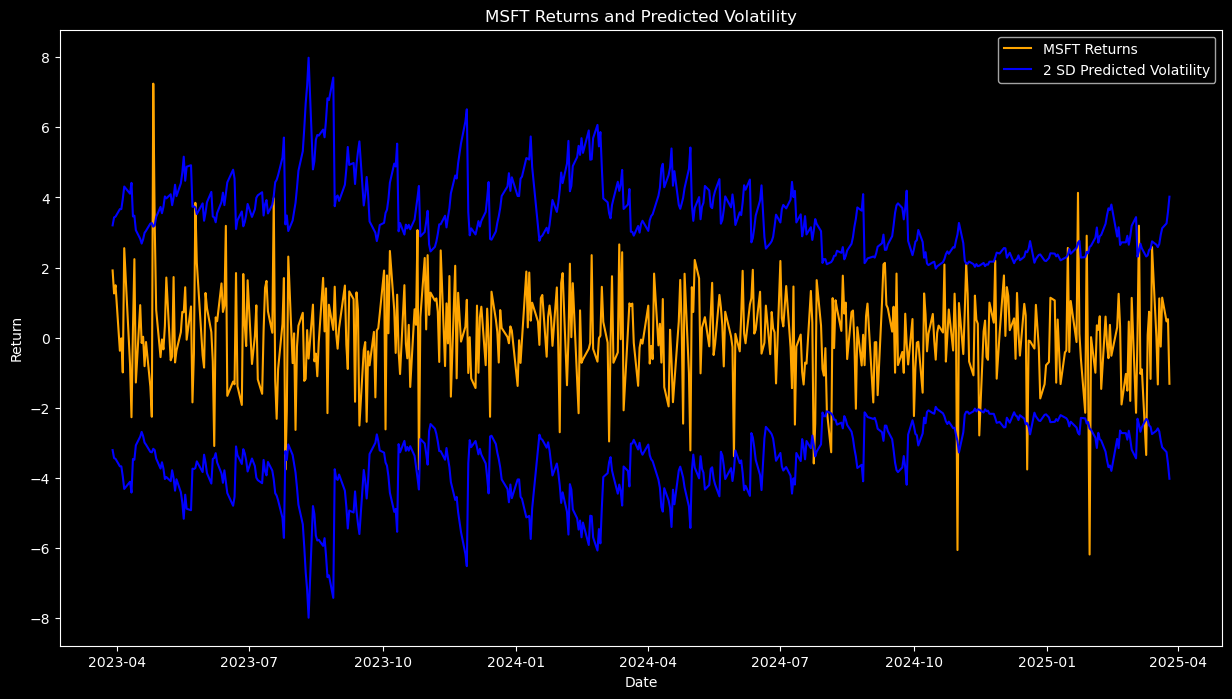

In [ ]:
# ----------------------------------------------------------------------------------------------

# Plot the time series of the walk-forward predicted volatility and the returns
fig = plt.figure(figsize=(15, 8))
fig.patch.set_facecolor("black")
plt.style.use("dark_background")

# Plot the MSFT returns, the predicted volatility, and the 2 SD confidence interval
plt.plot(msft_stock_returns.tail(test_size), label="MSFT Returns", color="Orange")
plt.plot(
    2 * forecasted_volatility, label="2 SD Predicted Volatility", color="blue"
)  # Multiply by 2 SD for better visualization
plt.plot(
    -2 * forecasted_volatility.rename(), color="blue"
)  # Multiply by -2 for better visualization
plt.title("MSFT Returns and Predicted Volatility")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show();

In [ ]:
# ----------------------------------------------------------------------------------------------
# 6. Communicate the Results
# ----------------------------------------------------------------------------------------------

# Create a function 'volatility_forecaster' that returns
# #the model's forecasted volatility for the next 'n' days


def volatility_forecaster(stock_data: pd.Series, n_days: int) -> dict:
    """
    Forecast the volatility of a stock for the next 'n' business days.

    Parameters:
    stock_data (pd.Series): A time series of stock returns.
    n_days (int): The number of business days to forecast.

    Returns:
    dict: A dictionary where each key is a business date
    in ISO 8601 format and each value is the predicted volatility.
    """
    # Fit the GARCH model
    model = arch_model(stock_data, p=1, q=1, rescale=False).fit(disp=0)

    # Generate forecasts
    forecasts = model.forecast(horizon=n_days, reindex=False).variance

    # Calculate forecast start date
    start_date = stock_data.index[-1] + pd.DateOffset(
        days=1
    )  # Get the last date in the stock data and add one day

    # Create date range for business days
    predicted_dates = pd.bdate_range(start=start_date, periods=n_days)

    # Extract predictions and take square root to get volatility
    volatility = forecasts.iloc[-1].values ** 0.5

    # Combine into a pandas Series
    predicted_output = pd.Series(
        volatility, index=[d.isoformat() for d in predicted_dates]
    )

    # Return as dictionary
    return predicted_output.to_dict()

In [ ]:
# Forecast the volatility for the next 10 days using the 'volatility_forecaster' function
volatility_forecaster(msft_stock_returns, 10)

{'2025-03-27T00:00:00': 1.3533461916214762,
 '2025-03-28T00:00:00': 1.3741686857018873,
 '2025-03-31T00:00:00': 1.3934490389306464,
 '2025-04-01T00:00:00': 1.41132397852267,
 '2025-04-02T00:00:00': 1.427914561085687,
 '2025-04-03T00:00:00': 1.4433285402262,
 '2025-04-04T00:00:00': 1.457662282479562,
 '2025-04-07T00:00:00': 1.4710023343889296,
 '2025-04-08T00:00:00': 1.4834267167599244,
 '2025-04-09T00:00:00': 1.4950060031022907}

In [ ]:
# ----------------------------------------------------------------------------------------------
# 7. Update the "APIStockProcessor class" in the "stock_data_processor.py"
# ----------------------------------------------------------------------------------------------

"""This will be used to build an interactive web app deployed for stock volatility forecasting.
"""

'This will be used to build an interactive web app deployed for stock volatility forecasting.\n'